<a href="https://colab.research.google.com/github/pvanand07/Retail-Sales-Prediction-Regression/blob/master/1_3_RS_Gradient_Boosting_%7C_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Import Dataset

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, auc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def Load_Dataset():
  df = pd.read_csv('/content/drive/MyDrive/Almabetter/Almabetter Projects/Data & Resources/Rossmann Stores Data.csv')
  df2 = pd.read_csv('/content/drive/MyDrive/Almabetter/Almabetter Projects/Data & Resources/store.csv')
  return df,df2
def merge_data(df,df2):
  df.set_index('Store', inplace=True)
  df2.set_index('Store', inplace=True)
  df_m = df.join(df2, on='Store')
  return df_m
df,df2 = Load_Dataset()
df_m = merge_data(df,df2)

### 2. Data Cleaning

In [ ]:
# Selecting only the rows with Open = 1
df_m2 = df_m[df_m['Open'] == 1].drop('Open', axis=1).copy()

# Converting Date to Datetime for analysis and feature engineering
df_m2['Date'] = pd.to_datetime(df_m2['Date'])

# We can also convert object Dtype to category for reduced memory usage
for col in df_m2.select_dtypes('object').columns:
  df_m2[col] = df_m2[col].astype('category')

# Replace all variations of "0" with a single representation
df_m2['StateHoliday'] = df_m2['StateHoliday'].replace(['0', 0], '0')

### 3. Data Preprocessing

In [ ]:
# Data pre-processing
def cap_outliers(df):
    # Create a copy of the DataFrame to avoid modifying the original data
    cleaned_df = df.copy()

    # Iterate over numerical columns
    for column in cleaned_df.select_dtypes(include=np.number):
        # Calculate the 99th percentile value
        cap_value = cleaned_df[column].quantile(0.95)

        # Cap outliers to the 99th percentile value
        cleaned_df[column] = np.where(cleaned_df[column] > cap_value, cap_value, cleaned_df[column])

    return cleaned_df

def pre_processing2(df_m):

  target_col = 'Sales'
  df_c = df_m.drop_duplicates().copy()
  df_c = df_c.dropna()#.sample(n = 5000, random_state = 42)
  #df_c = df_c.sample(n = 5000, random_state = 42)

  # Generate  week_number, month and year columns from datetime
  df_c['week_number'] = (df_c['Date']).dt.week
  df_c['month'] = (df_c['Date']).dt.month
  df_c['year'] = (df_c['Date']).dt.year
  df_c.drop(['Date'], axis=1, inplace=True)#,'Customers'

  df_c = cap_outliers(df_c)


  # Separate features and target
  X = df_c.drop(target_col, axis=1)
  y = df_c[target_col]

  # Perform one-hot encoding for categorical features
  categorical_features = X.select_dtypes(include='category').columns.tolist()
  X_encoded = pd.get_dummies(X, columns=categorical_features)


  return X_encoded,y

In [ ]:
X,y= pre_processing2(df_m2)
X.describe()

,DayOfWeek,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
count,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.000000,267812.0,267812.000000,267812.000000,...,267812.000000,267812.0,267812.000000,267812.000000,267812.000000,267812.0,267812.000000,267812.000000,267812.000000,267812.000000
mean,3.509156,658.462825,0.446799,0.190193,4155.145102,7.188464,2008.169630,1.0,21.860779,2011.832244,...,0.549173,0.0,0.130879,0.319948,0.582431,0.0,0.417569,0.217414,0.609256,0.173331
std,1.713761,246.013467,0.497162,0.392454,4840.393380,3.249393,7.384723,0.0,13.129778,1.637826,...,0.497577,0.0,0.337269,0.466457,0.493159,0.0,0.493159,0.412487,0.487918,0.378533
min,1.000000,0.000000,0.000000,0.000000,40.000000,1.000000,1900.000000,1.0,1.000000,2009.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,479.000000,0.000000,0.000000,600.000000,4.000000,2005.000000,1.0,13.000000,2011.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.000000,614.000000,0.000000,0.000000,2230.000000,7.000000,2009.000000,1.0,18.000000,2012.000000,...,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,5.000000,799.000000,1.000000,0.000000,5630.000000,10.000000,2012.000000,1.0,37.000000,2013.000000,...,1.000000,0.0,0.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000
max,6.000000,1211.000000,1.000000,1.000000,17110.000000,12.000000,2014.000000,1.0,40.000000,2014.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


### Stats Model Results

### 3. Feature Selection and Engineering

In [ ]:
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def calculate_vif(df):
    # Select numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64'])

    # Replace infinite values with NaN
    numerical_columns.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values
    numerical_columns.dropna(inplace=True)

    # Remove duplicates
    numerical_columns = numerical_columns.loc[:,~numerical_columns.columns.duplicated()]

    # Create a DataFrame to store VIF results
    vif_data = pd.DataFrame()
    vif_data['Variable'] = numerical_columns.columns
    vif_data['VIF'] = [vif(numerical_columns.values, i) for i in range(numerical_columns.shape[1])]

    return vif_data.sort_values(by='VIF', ascending=False)

calculate_vif(df_m2.drop(['Sales'], axis=1))

,Variable,VIF
7,Promo2,1.573677e+06
2,Promo,1.153423e+00
1,Customers,1.119583e+00
0,DayOfWeek,1.117165e+00
4,CompetitionDistance,1.059632e+00
9,Promo2SinceYear,1.037353e+00
3,SchoolHoliday,1.020993e+00
8,Promo2SinceWeek,1.019017e+00
6,CompetitionOpenSinceYear,1.010080e+00
5,CompetitionOpenSinceMonth,1.009137e+00


In [ ]:
calculate_vif((df_m2).drop(['Promo2','Promo2SinceYear','Sales','CompetitionOpenSinceYear'], axis=1))

,Variable,VIF
1,Customers,5.140540
5,CompetitionOpenSinceMonth,4.461682
0,DayOfWeek,4.066374
6,Promo2SinceWeek,3.218630
2,Promo,2.017833
4,CompetitionDistance,1.600253
3,SchoolHoliday,1.230049


In [ ]:
df_m2.columns

Index(['DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
df_m2['PromoInterval']

Store
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
    ... 
1    NaN
1    NaN
1    NaN
1    NaN
1    NaN
Name: PromoInterval, Length: 781, dtype: category
Categories (3, object): ['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec']

In [ ]:
df['Promo_Month'] = df['PromoInterval'].apply(lamda x: 1 if x)

In [ ]:
df_m2.sample(15)

,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Store,,,,,,,,,,,,,,,,
904,4,2015-01-22,4354,428,0,0,0,d,c,570.0,7.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
979,5,2013-09-13,6350,668,1,0,0,a,c,2270.0,11.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
678,3,2013-03-13,5243,702,0,0,0,c,a,3250.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
274,6,2014-09-27,3161,835,0,0,0,b,b,3640.0,NaN,NaN,1,10.0,2013.0,"Jan,Apr,Jul,Oct"
218,2,2015-04-21,4774,711,0,0,0,a,c,640.0,NaN,NaN,1,9.0,2011.0,"Mar,Jun,Sept,Dec"
312,1,2013-12-16,12264,873,1,0,0,d,a,11300.0,3.0,2012.0,0,NaN,NaN,NaN
48,5,2013-07-19,3895,475,1,0,1,a,a,1060.0,5.0,2012.0,0,NaN,NaN,NaN
474,4,2014-01-16,5753,624,0,0,0,c,a,14810.0,NaN,NaN,1,14.0,2011.0,"Mar,Jun,Sept,Dec"
797,3,2013-07-10,3370,327,0,0,0,a,a,2090.0,10.0,2012.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


### Model 2: Gradient Boosting Regression (sklearn)

In [ ]:
df_m2.columns

Index(['DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#mport gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


# Assuming `pre_processing2` returns X_train, X_test, y_train, y_test
X,y = pre_processing2((df_m2.sample(10000, random_state=42).drop(['Customers'], axis=1)))#.drop(['Customers'], axis=1)))#.drop(['Promo2','Promo2SinceYear'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the scaler and fit/transform X_train and X_test

scaler = MinMaxScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Apply square root transformation to y_train and y_test
y_train_s = np.sqrt(y_train)
y_test_s = np.sqrt(y_test)

stats = {}

# Perform regression analysis
X = X_train_s
y = y_train_s
#regressor = DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=15, random_state=0)
regressor = GradientBoostingRegressor()
regressor.fit(X, y)
y_pred = regressor.predict(X_test_s)
print('Train R2 score:', regressor.score(X_train_s, y_train_s))
print('Test R2 score:', regressor.score(X_test_s, y_test_s))


Train R2 score: 0.609528503238417
Test R2 score: 0.5338058501165058


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [150, 200,250],
    'learning_rate': [1,0.1, 0.01],
    'max_depth': [4,5,7,9]
}

# Create the GradientBoostingRegressor
regressor = GradientBoostingRegressor(random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(regressor, param_grid, cv=5)
grid_search.fit(X_train_s, y_train_s)

# Get the best model and its hyperparameters
best_regressor = grid_search.best_estimator_
best_params = grid_search.best_params_

# Use the best model to make predictions
y_pred = best_regressor.predict(X_test_s)

In [ ]:
print(best_regressor.score(X, y))
print(best_regressor.score(X_test_s, y_test_s))

0.925310011860434
0.7513558207867763


In [ ]:
print('Best parameters:', best_params)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


Random Forrest Regression: train:0.9960095559974053
Test score:                      0.9720660671115722

In [ ]:
regressor.feature_importances_

In [ ]:
pd.DataFrame(regressor.feature_importances_, X_train.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)

In [ ]:
pd.DataFrame(y_pred).describe()
pd.DataFrame(y_test_s).describe()

In [ ]:
plt.scatter(y_pred,y_test_s)

In [ ]:
### Heteroscadacity
plt.scatter(y_pred,y_test_s-y_pred)
plt.xlabel('Predicted sales')
plt.ylabel('residuals')

### Model 3: Xtream Gradient Boosting Regression (sklearn)

In [ ]:
df_m2.columns

Index(['DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#mport gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


# Assuming `pre_processing2` returns X_train, X_test, y_train, y_test
X,y = pre_processing2((df_m2.drop(['Customers'], axis=1)))#.drop(['Promo2','Promo2SinceYear'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the scaler and fit/transform X_train and X_test

scaler = MinMaxScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_s = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Apply square root transformation to y_train and y_test
y_train_s = np.sqrt(y_train)
y_test_s = np.sqrt(y_test)

stats = {}

# Perform regression analysis
X = X_train_s
y = y_train_s
#regressor = DecisionTreeRegressor(criterion='friedman_mse', max_leaf_nodes=15, random_state=0)
regressor = XGBRegressor()
regressor.fit(The existing website is a simple search page with a gradient background that changes based on the time of day. The core functions and features of the website include:
Gradient background: The background color changes according to the time of day (twilight, sunrise, day, evening).
Search input: A search input field with a placeholder text "Search".
Language switcher: A clickable element to switch languages.
Search suggestions: A list of search suggestions that appear below the search input field.
Footer: Contains copyright information, terms of service, privacy policy, and cookies policy links.
Prompt for building a similar website:
Step 1: Set up the HTML structure
Create the basic HTML structure with a form for the search input, a div for the gradient background, and a footer for the legal information.
html

Copy

<!doctype html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Search Page</title>
  <!-- Add your CSS and JS links here -->
</head>
<body>
  <div id="gradient"></div>
  <div id="container">
    <form id="form">
      <div id="input">
        <input id="i" type="text" autocomplete="off" spellcheck="false" placeholder="Search" />
      </div>
      <a id="lang"></a>
      <ul id="sugs"></ul>
    </form>
  </div>
  <footer>
    <!-- Add your legal information here -->
  </footer>
</body>
</html>
Step 2: Style the website with CSS
Create a CSS file to style the elements, including the gradient background, search input, language switcher, search suggestions, and footer.
css

Copy

/* Add your CSS styles for the gradient background, search input, language switcher, search suggestions, and footer here */
Step 3: Add JavaScript for the gradient background and search functionality
Create a JavaScript file to handle the gradient background change based on the time of day and the search functionality.
javascript

Copy

// Gradient background based on time of day
var currentTime = new Date().getHours();
var element = document.getElementById("gradient");

if (5 <= currentTime && currentTime < 7) {
  element.className = "twilight";
} else if (7 <= currentTime && currentTime < 9) {
  element.className = "sunrise";
} else if (9 <= currentTime && currentTime < 18) {
  element.className = "day";
} else if (18 <= currentTime && currentTime < 20) {
  element.className = "evening";
} else if (20 <= currentTime && currentTime < 22) {
  element.className = "twilight";
}

// Add your JavaScript code for search functionality, language switcher, and search suggestions here
Step 4: Implement the search functionality, language switcher, and search suggestions
Add the necessary JavaScript code to handle the search functionality, language switcher, and search suggestions. You may use external libraries or APIs to fetch search suggestions and handle language switching.
Step 5: Ensure responsiveness and usability
Make sure the website is responsive and works well on different devices and screen sizes. Test the website on various browsers to ensure compatibility.
By following these steps and using the provided code snippets as a starting point, developers can build a similar website with the same functions and features

add the above page style and functionalities to the following code
<!DOCTYPE html>
<html>
<head>
  <title>Multi-Search Engine</title>
  <style>
    body {
      font-family: Arial, sans-serif;
      text-align: center;
      padding: 20px;
    }

    input[type="text"] {
      width: 400px;
      height: 30px;
      padding: 5px;
      font-size: 16px;
    }

    input[type="submit"] {
      height: 30px;
      padding: 0 10px;
      font-size: 16px;
      cursor: pointer;
    }

    ul {
      list-style-type: none;
      padding: 0;
      margin-bottom: 10px;
    }

    li {
      display: inline;
      margin-right: 10px;
    }

    a {
      text-decoration: none;
    }
  </style>
</head>
<body>
  <h1>Multi-Search Engine</h1>

  <ul id="searchProviders">
    <li><input type="radio" name="provider" value="google" checked> Google</li>
    <li><input type="radio" name="provider" value="bing"> Bing</li>
    <li><input type="radio" name="provider" value="duckduckgo"> DuckDuckGo</li>
  </ul>

  <form id="searchForm">
    <input type="text" id="query" placeholder="Enter your query">
    <input type="submit" value="Search">
  </form>

  <div id="results">
    <ul id="searchResults"></ul>
  </div>

  <script>
    document.getElementById('searchForm').addEventListener('submit', function(event) {
      event.preventDefault();
      var query = document.getElementById('query').value;
      var selectedProvider = document.querySelector('input[name="provider"]:checked').value;
      searchOnEngine(query, selectedProvider);
    });

    function searchOnEngine(query, provider) {
      var searchResults = document.getElementById('searchResults');
      searchResults.innerHTML = '';

      var engines = {
        google: { name: 'Google', url: 'https://www.google.com/search?q=' },
        bing: { name: 'Bing', url: 'https://www.bing.com/search?q=' },
        duckduckgo: { name: 'DuckDuckGo', url: 'https://duckduckgo.com/html/?q=' }
      };

      var engine = engines[provider];
      var li = document.createElement('li');
      var link = document.createElement('a');
      link.href = engine.url + encodeURIComponent(query);
      link.textContent = engine.name;
      li.appendChild(link);
      searchResults.appendChild(li);
    }
  </script>
</body>
</html>
X, y)
y_pred = regressor.predict(X_test_s)

In [ ]:
print(regressor.score(X, y))
print(regressor.score(X_test_s, y_test_s))

0.900543941916797
0.897781799315858


Random Forrest Regression: train:0.9960095559974053
Test score:                      0.9720660671115722

In [ ]:
regressor.feature_importances_

array([0.01204597, 0.33408585, 0.09416395, 0.00295027, 0.02724965,
       0.01597447, 0.01959174, 0.        , 0.0244611 , 0.01889244,
       0.00575697, 0.01228974, 0.00700296, 0.00137046, 0.        ,
       0.        , 0.        , 0.00793972, 0.        , 0.0207489 ,
       0.3318167 , 0.03511707, 0.        , 0.        , 0.00975118,
       0.01522613, 0.00356475], dtype=float32)

In [ ]:
pd.DataFrame(regressor.feature_importances_, X_train.columns, columns=['Coefficient']).sort_values('Coefficient', ascending=False)

,Coefficient
Customers,0.334086
StoreType_d,0.331817
Promo,0.094164
Assortment_a,0.035117
CompetitionDistance,0.027250
Promo2SinceWeek,0.024461
StoreType_c,0.020749
CompetitionOpenSinceYear,0.019592
Promo2SinceYear,0.018892
CompetitionOpenSinceMonth,0.015974


In [ ]:
pd.DataFrame(y_pred).describe()
pd.DataFrame(y_test_s).describe()

,Sales
count,53563.000000
mean,78.709717
std,14.957155
min,0.000000
25%,68.102863
50%,77.942286
75%,88.932559
max,107.459062


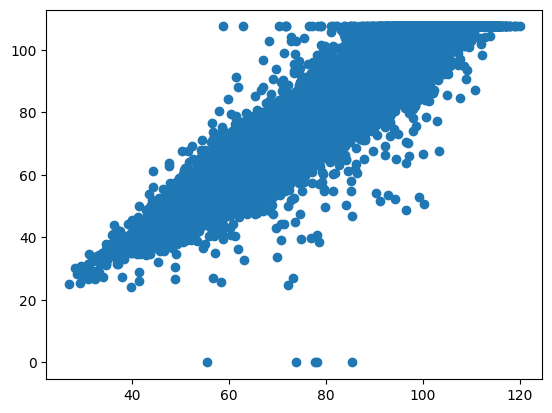

In [ ]:
plt.scatter(y_pred,y_test_s)

Text(0, 0.5, 'residuals')

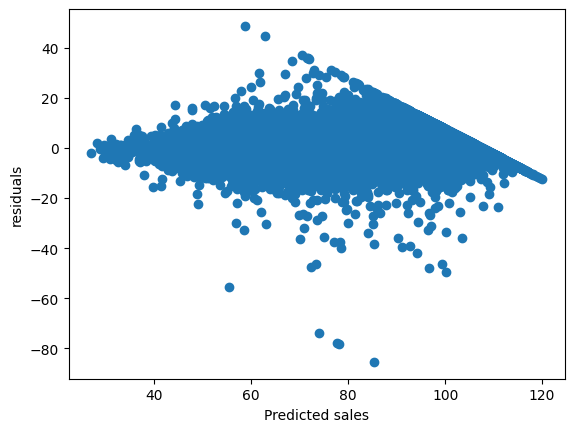

In [ ]:
### Heteroscadacity
plt.scatter(y_pred,y_test_s-y_pred)
plt.xlabel('Predicted sales')
plt.ylabel('residuals')

## V2 Gradient Boosting Regression